In [12]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [13]:
# Configura TensorFlow para usar precisión de 64 bits en los cálculos
tf.keras.backend.set_floatx("float64")

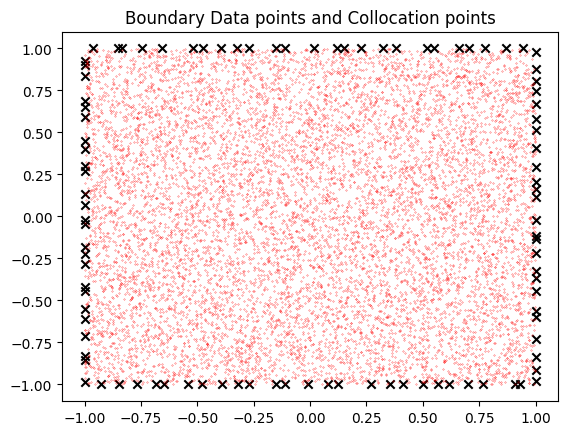

In [15]:
### Generación de datos
n_bc = 4  # Número de condiciones de frontera
n_data_per_bc = 25  # Número de puntos por condición de frontera


# Inicializa un generador de secuencias de números con el método Latin Hypercube
engine = qmc.LatinHypercube(d=1)
data = np.zeros([4, 25, 3])



# Genera puntos de frontera para las 4 condiciones de frontera
for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j
        
        
        
# Valores de las condiciones de frontera normalizados en [0, 1]
data[0, :, 2] = 1.0
data[2, :, 2] = 50/75

# Reestructura los datos en un solo array
data = data.reshape(n_data_per_bc * n_bc, 3)
x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1), 
                    [data[:, 0], data[:, 1], data[:, 2]])



### Puntos de colación
Nc = 10000  # Número de puntos de colación
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc - 0.5)
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])


plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()



# Convierte los datos a tensores de TensorFlow
x_c, y_c, x_d, y_d, t_d = map(lambda x: tf.convert_to_tensor(x, dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [16]:
### Función para construir el modelo DNN
# Define y construye una red neuronal profunda con 9 capas ocultas y 20 neuronas por capa utilizando la función de activación tanh

def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10, 
                neuron_per_layer=20, actfn="tanh"):
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [17]:
# Limpia la sesión de Keras y construye el modelo DNN
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 9, 20, "tanh")

# Función para graficar el modelo (opcional)
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,441 (26.88 KB)

 Trainable params: 3,441 (26.88 KB)

 Non-trainable params: 0 (0.00 B)

AttributeError: module 'pydot' has no attribute 'InvocationException'

In [18]:
# Tensorflow functions

# Calcula la salida del modelo DNN
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u


# Calcula el término de la ecuación diferencial parcial.
@tf.function
def f(x, y):
    u0 = u(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    F = u_xx + u_yy
    return tf.reduce_mean(tf.square(F))


# Calcula el error cuadrático medio.
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 0.912
  200, 0.046
  400, 0.040
  600, 0.028
  800, 0.021
  999, 0.020

computation time: 101.121



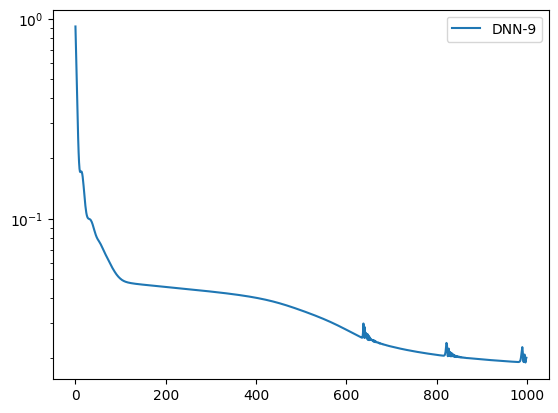

In [19]:
# Loss Function
loss = 0
epochs = 1000
opt = tf.keras.optimizers.Adam(learning_rate=5e-4)
epoch = 0
loss_values = np.array([])


# Medicion de tiempo 
start = time.time()


# Entrenamiento del modelo PINN utilizando el optimizador Adam
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        loss = l + L
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    if epoch % 200 == 0 or epoch == epochs - 1:
        print(f"{epoch:5}, {loss.numpy():.3f}")

# Medicion de tiempo 
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end - start:.3f}\n")

# Grafica la evolución de la pérdida durante el entrenamiento
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [20]:
# Simulación utilizando el Método de Diferencias Finitas (FDM)
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])

# Condiciones de frontera
bc = {
    "x=-l": 75.,
    "x=+l": 0.,
    "y=-l": 50.,
    "y=+l": 0.
}

B = np.zeros([n, n])
k = 0
for i in range(n):
    x = i * r
    for j in range(n):
        y = j * r
        M = np.zeros([n, n])
        M[i, j] = -4
        if i != 0: # ok i know
            M[i-1, j] = 1
        else:
            B[i, j] += -bc["y=-l"]   # b.c y = 0
        if i != n-1:
            M[i+1, j] = 1
        else:
            B[i, j] += -bc["y=+l"]   # b.c y = l
        if j != 0:
            M[i, j-1] = 1
        else:
            B[i, j] += -bc["x=-l"]   # b.c x = 0
        if j != n-1:
            M[i, j+1] = 1
        else:
            B[i, j] += -bc["x=+l"]   # b.c x = l
        #B[i, j] += -r**2 * q(x, y) * K(x, y)
        m = np.reshape(M, (1, n**2))
        T[k, :] = m
        k += 1

#
b = np.reshape(B, (n**2, 1))
start = time.time()
T = np.matmul(np.linalg.inv(T), b)
T = T.reshape([n, n])
Temperature = T
end = time.time()
computation_time["fdm"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")


computation time: 10.355



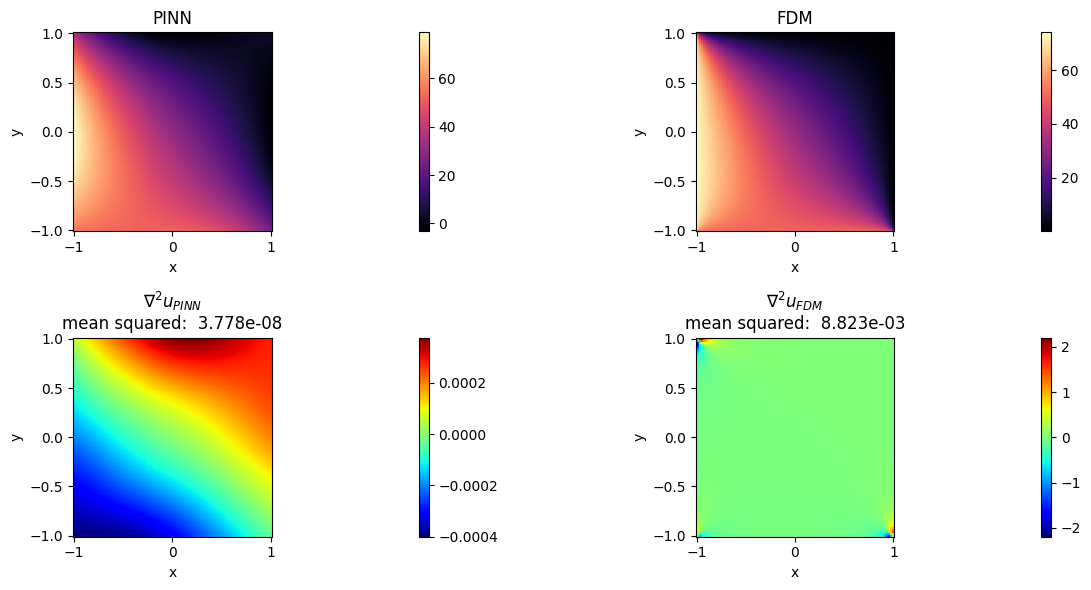

In [21]:
### Graficado de resultados
plt.figure("", figsize=(12, 6))
#
X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)


# Resultados de la Red Neuronal (PINN)
plt.subplot(221)
plt.pcolormesh(X0, Y0, 75.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")


# Resultados del Método de Diferencias Finitas (FDM)
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)


plt.subplot(222)
plt.pcolormesh(x, y, T, cmap="magma")
plt.colorbar()
plt.title(r"FDM")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")


# Gradientes de la solución obtenida por la PINN
plt.subplot(223)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"${\nabla^{2}{u_{PINN}}}$" + f"\nmean squared: {sigma_pinn: .3e}")
plt.tight_layout()
plt.axis("square")
###
x = np.linspace(-1, +1, n)
y = np.linspace(-1, +1, n)
x, y = np.meshgrid(x, y)


# Gradientes de la solución obtenida por el FDM
plt.subplot(224)
fdm_grad = np.gradient(np.gradient(T, axis=0), axis=1)
sigma_fdm = (fdm_grad**2).mean()
plt.pcolormesh(x, y, fdm_grad, cmap="jet")
plt.colorbar()
plt.title(r"${\nabla^{2}{u_{FDM}}}$" + f"\nmean squared: {sigma_fdm: .3e}")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-1, +1)
plt.ylim(-1, +1)
plt.tight_layout()
plt.axis("square")
plt.savefig("heat01.png")
plt.show()

In [22]:
print("performance comparison".center(26))
print("="*26)
for method in computation_time:
    print(f"{method}\t\t{computation_time[method]:6.2f} (s)")

  performance comparison  
pinn		101.12 (s)
fdm		 10.36 (s)
